In [1]:
# first load required libraries
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

In [2]:
# Loan_train.csv data set includes details of customer 
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2020-04-18 20:28:16--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: 'loan_train.csv'

     0K .......... .......... ..                              100%  214K=0.1s

2020-04-18 20:28:17 (214 KB/s) - 'loan_train.csv' saved [23101/23101]



In [3]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [4]:
df.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'loan_status', 'Principal', 'terms',
       'effective_date', 'due_date', 'age', 'education', 'Gender'],
      dtype='object')

In [5]:
# Convert to date time object
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing

Find how many of customer pasid loan and how many didn't

In [6]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

Plot some columns to understand data better

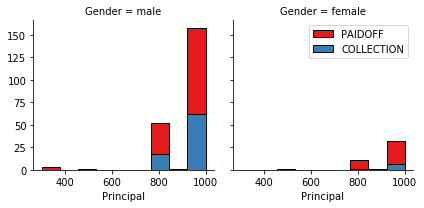

In [7]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

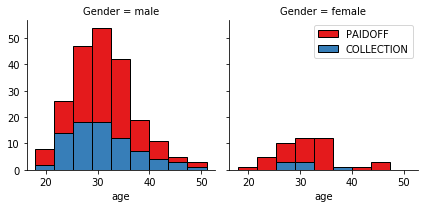

In [8]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

Find day of the week people got loan

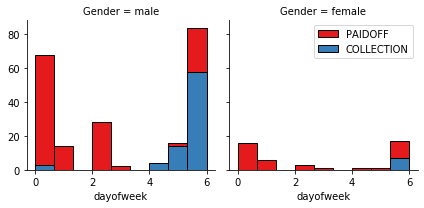

In [9]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()

Female customers who get the loan at the end of the week don't pay it off and male customers who got loan from day 4 of a week are most likely to not pay. So use Feature binarization to set a threshold values less then day 4

In [10]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

Look at gender

In [11]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86.5 % of female pay there loans while only 73 % of males pay there loan, convert male to 0 and female to 1

In [12]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding

Look at customers education

In [13]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

Since 50% customers with master or Above paid, we can't use them to determine if they will pay loan or not, so drop them

use one hot encoding technique to convert categorical variables of 'education' to binary variables and append them to the Feature Data Frame

In [18]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature.head()

,Principal,terms,age,Gender,weekend
0,1000,30,45,0,0
1,1000,30,33,1,0
2,1000,15,27,0,0
3,1000,30,28,1,1
4,1000,30,29,0,1


In [19]:
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.head(10)

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,Master or Above,college
0,1000,30,45,0,0,0,1,0,0
1,1000,30,33,1,0,1,0,0,0
2,1000,15,27,0,0,0,0,0,1
3,1000,30,28,1,1,0,0,0,1
4,1000,30,29,0,1,0,0,0,1
5,1000,30,36,0,1,0,0,0,1
6,1000,30,28,0,1,0,0,0,1
7,800,15,26,0,1,0,0,0,1
8,300,7,29,0,1,0,0,0,1
9,1000,15,39,0,1,0,1,0,0


In [20]:
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


In [50]:
Feature.shape

(346, 8)

## Feature selection

In [21]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


In [52]:
X.shape

(346, 8)

In [22]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

In [54]:
y.shape

(346,)

### Normalize Data

In [23]:
# Data Standardization give data zero mean and unit variance (technically should be done after train test split )

X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

## K Nearest Neighbor(KNN)

Find the best k to build the model with the best accuracy

In [24]:
#Run train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)

#print ('Train set:', X_train.shape,  y_train.shape)
#print ('Test set:', X_test.shape,  y_test.shape)

In [49]:
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (276, 8) (276,)
Test set: (70, 8) (70,)


In [27]:
#find best value of K
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

Kvals = 15
mean_accuracy = np.zeros((Kvals-1))
std_accuracy = np.zeros((Kvals-1))
for n in range(1,Kvals):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_accuracy[n-1] = metrics.accuracy_score(y_test, yhat)

    
    std_accuracy[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

mean_accuracy

array([0.67142857, 0.65714286, 0.71428571, 0.68571429, 0.75714286,
       0.71428571, 0.78571429, 0.75714286, 0.75714286, 0.67142857,
       0.7       , 0.72857143, 0.7       , 0.7       ])

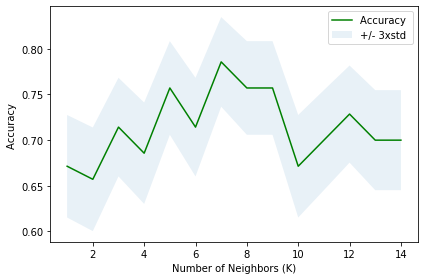

In [29]:
#plot accuracy vs k values
plt.plot(range(1,Kvals),mean_accuracy,'g')
plt.fill_between(range(1,Kvals),mean_accuracy - 1 * std_accuracy,mean_accuracy + 1 * std_accuracy, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

From above we can see that best value of K is 7

In [30]:
print( "The best accuracy was with", mean_accuracy.max(), "with k=", mean_accuracy.argmax()+1) 

The best accuracy was with 0.7857142857142857 with k= 7


## Decision Tree

In [31]:
#train decision tree model
from sklearn.tree import DecisionTreeClassifier
loanTree = DecisionTreeClassifier(criterion="entropy", max_depth = 6)
loanTree.fit(X_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=6, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [32]:
#predict target variable
predDT = loanTree.predict(X_test)

In [33]:
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_test, predDT))

DecisionTrees's Accuracy:  0.7714285714285715


## Support Vector Machine

In [34]:
#Find the best kernel to use
from sklearn import svm
acc_score = np.zeros(3)
n = 0

for kernel in ('linear', 'poly', 'rbf'):
    clf = svm.SVC(kernel=kernel)
    clf.fit(X_train, y_train)
    svm_yhat = clf.predict(X_test)
    acc_score[n] = metrics.accuracy_score(y_test, svm_yhat)
    n = n + 1

acc_score

array([0.78571429, 0.77142857, 0.74285714])

linear has 0.79 score and has best accuracy

In [35]:
clf = svm.SVC(kernel='linear')
clf.fit(X_train, y_train)
svm_yhat = clf.predict(X_test)
svm_yhat [0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

In [37]:
print("SVM Accuracy: ", metrics.accuracy_score(y_test, svm_yhat))

SVM Accuracy:  0.7857142857142857


## Logistic Regression

In [38]:
from sklearn.linear_model import LogisticRegression
#find optimal solver parameter
LR_accu = np.zeros(5)
n = 0

for solver in ('newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga' ):
    LR = LogisticRegression(C=0.01, solver=solver)
    LR.fit(X_train, y_train)
    LR_yhat = LR.predict(X_test)
    LR_accu[n] = metrics.accuracy_score(y_test, LR_yhat)
    n = n + 1

LR_accu

array([0.78571429, 0.78571429, 0.68571429, 0.78571429, 0.78571429])

In [39]:
# We can see from the LR_accu array above all the possible solver values have the same accuracy except liblinear
LR = LogisticRegression(C=0.01, solver='lbfgs')
LR.fit(X_train, y_train)
LR_yhat = LR.predict(X_test)
LR_yhat[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

In [40]:
print("Logistic Regression Accuracy: ", metrics.accuracy_score(y_test, LR_yhat))

Logistic Regression Accuracy:  0.7857142857142857


## Model Evaluation Test data set

In [47]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

In [55]:
# Download and load the test set:

!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2020-04-18 22:06:36--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: 'loan_test.csv'

     0K ...                                                   100% 12.9M=0s

2020-04-18 22:06:36 (12.9 MB/s) - 'loan_test.csv' saved [3642/3642]



In [56]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [57]:
#convert to date object
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])

#add day of week and weekend columns
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)

#convert Gender column to binary
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)

Feature_df = test_df[['Principal','terms','age','Gender','weekend']]
Feature_df = pd.concat([Feature_df,pd.get_dummies(test_df['education'])], axis=1)
Feature_df.drop(['Master or Above'], axis = 1,inplace=True)
Feature_df.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,50,1,0,1,0,0
1,300,7,35,0,1,0,0,0
2,1000,30,43,1,1,0,1,0
3,1000,30,26,0,1,0,0,1
4,800,15,29,0,1,1,0,0


In [58]:
X = Feature_df
y = test_df['loan_status'].values

In [59]:
#predict using KNN algo's
yhat = neigh.predict(X)
yhat

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

In [66]:
#predict using Decission Tree algo's
predDT = loanTree.predict(X)
predDT

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'COLLECTION', 'COLLECTION',
       'PAIDOFF', 'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'COLLECTION', 'PAIDOFF',
       'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'COLLECTION',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'COLLECTION',
       'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'COLLECTION', 'PAIDOFF',
       'COLLECTION', 'COLLECTION', 'COLLECTION'], dtype=object)

In [61]:
#predict using SVM algo's
svm_yhat = clf.predict(X)
svm_yhat

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

In [62]:
#predict using Logistic Regression algo's
LR_yhat = LR.predict(X)
LR_yhat

array(['COLLECTION', 'COLLECTION', 'COLLECTION', 'COLLECTION',
       'COLLECTION', 'COLLECTION', 'COLLECTION', 'COLLECTION',
       'COLLECTION', 'COLLECTION', 'COLLECTION', 'COLLECTION',
       'COLLECTION', 'COLLECTION', 'COLLECTION', 'COLLECTION',
       'COLLECTION', 'COLLECTION', 'COLLECTION', 'COLLECTION',
       'COLLECTION', 'COLLECTION', 'COLLECTION', 'COLLECTION',
       'COLLECTION', 'COLLECTION', 'COLLECTION', 'COLLECTION',
       'COLLECTION', 'COLLECTION', 'COLLECTION', 'COLLECTION',
       'COLLECTION', 'COLLECTION', 'COLLECTION', 'COLLECTION',
       'COLLECTION', 'COLLECTION', 'COLLECTION', 'COLLECTION',
       'COLLECTION', 'COLLECTION', 'COLLECTION', 'COLLECTION',
       'COLLECTION', 'COLLECTION', 'COLLECTION', 'COLLECTION',
       'COLLECTION', 'COLLECTION', 'COLLECTION', 'COLLECTION',
       'COLLECTION', 'COLLECTION'], dtype=object)

In [67]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
mlb.fit(y)

KNN_fs = f1_score(mlb.transform(y), mlb.transform(yhat), average='micro')
DT_fs = f1_score(mlb.transform(y), mlb.transform(predDT), average='micro')
SVM_fs = f1_score(mlb.transform(y), mlb.transform(svm_yhat), average='micro')
LG_fs = f1_score(mlb.transform(y), mlb.transform(LR_yhat), average='micro')

yhat_proba = LR.predict_proba(X)

accuracy = {'Algorithm': ['k-Nearest Neighbour','Decision Tree','Support Vector Machine','Logistic Regression'],
             'Jaccard':[jaccard_similarity_score(y, yhat), jaccard_similarity_score(y, predDT),
                       jaccard_similarity_score(y, svm_yhat),jaccard_similarity_score(y, LR_yhat)],
            'F1-score':[KNN_fs, DT_fs, SVM_fs, LG_fs],
            'LogLoss':['NA', 'NA', 'NA',log_loss(y, yhat_proba)]}

Report_df = pd.DataFrame(accuracy)
Report_df.set_index('Algorithm',inplace = True)

Report_df = Report_df[['Jaccard','F1-score','LogLoss']]

Report_df

C:\Users\prk\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:664: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  FutureWarning)


,Jaccard,F1-score,LogLoss
Algorithm,,,
k-Nearest Neighbour,0.740741,0.809668,NA
Decision Tree,0.722222,0.800591,NA
Support Vector Machine,0.740741,0.809668,NA
Logistic Regression,0.259259,0.497207,16.8619
